In [25]:
from glob import glob
import numpy as np
import json
import pandas as pd

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# TODO (August 8th)
- dpi + pretty figures
- xlabel, ylabel, xlim, ylim....

# Datasets vs accuracy

In [26]:
def summarize_final_results(data='cifar10', split='test', n_last=20):
    '''
    Calculate the mean and standard deviation of results of the last 'n_last' epochs.
    '''

    if data == 'cifar10':
        sample_sizes = [1000,2500,5000,25000,50000] # [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','sp','spBN']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                        ))
            if len(path_list) == 0:
                # After moving the files
                path_list = sorted(
                    glob(
                        '/data/dro-io_history/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                    ))
            
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            try: 
                tmp = pd.concat(tmp, sort=False)
                tmp_test = tmp.loc['test'].iloc[:,-n_last:]
            except:
                tmp
                tmp_test = tmp.loc['test'].iloc[-n_last:]

            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                        'mean': tmp_test.mean().mean(),
                        'std': tmp_test.std().mean()}
            df = df.append(tmp_dict, ignore_index=True)

    return df

In [27]:
def show_summary_plot(data='cifar10'):
    df_data = summarize_final_results(data=data, n_last=20)
    if data == 'cifar10':
        x_list = np.log([1000,2500,5000,25000,50000]) # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','sp','spBN']
    names=['ERM','Mixup','SP','spBN']
    colors=['dodgerblue','green','red','purple']
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i]) 
        plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    plt.legend(loc='lower right', borderaxespad=0., fontsize=13)
    plt.xlabel('$\log$(# of samples)')
    plt.title('Test accuracy: {}'.format(data))
    plt.show()
    

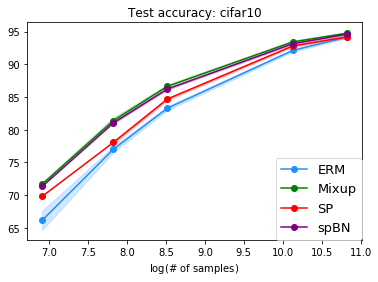

In [28]:
show_summary_plot(data='cifar10')

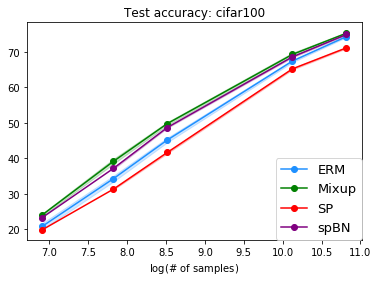

In [29]:
show_summary_plot(data='cifar100')

# Epochs vs generalization gap

In [65]:
def summarize_learning_history(data='cifar10'):
    
    if data == 'cifar10':
        sample_sizes = [1000,2500,5000,25000,50000] # [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','sp','spBN']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                        ))
            if len(path_list) == 0:
                # After moving the files
                path_list = sorted(
                    glob(
                        '/data/dro-io_history/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                    ))
            
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            if 'sp' not in model:
                tmp = pd.concat(tmp, sort=False)
                generalization_gap = np.array(tmp.loc['tr'])-np.array(tmp.loc['test'])
            else:
                tmp = tmp[0]
                generalization_gap = np.array(tmp.loc['tr'])-np.array(tmp.loc['test'])
                
            # generalization_gap = np.array(tmp.loc['tr'])-np.array(tmp.loc['test'])
            
            try: 
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': list(np.mean(generalization_gap, axis=0)),
                           'std': list(np.std(generalization_gap, axis=0))}
            except:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': list(generalization_gap),
                           'std': np.zeros(len(generalization_gap))}
            df = df.append(tmp_dict, ignore_index=True)

    return df


In [71]:
def show_generalization_gap(data='cifar10', sample=50000):
    df_cifar10_history = summarize_learning_history(data=data)
    x_list = np.arange(100)
    
    models=['erm','mixup','sp','spBN']
    names=['ERM','Mixup','SP','spBN']
    colors=['dodgerblue','green','red','purple']
    
    for i in range(len(colors)):
        ind = (df_cifar10_history['model']==models[i]) & (df_cifar10_history['sample']==sample)
        ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
        yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
        plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i]) 
        plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

    '''
    ind = (df_cifar10_history['model']=='erm') & (df_cifar10_history['sample']==sample)
    ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
    yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
    plt.plot(x_list, ymean, marker='o', color='dodgerblue', label='ERM') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='dodgerblue', facecolor='dodgerblue')

    ind = (df_cifar10_history['model']=='mixup') & (df_cifar10_history['sample']==sample)
    ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
    yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
    plt.plot(x_list, ymean, marker='o', color='red', label='Mixup') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='red', facecolor='red')
    '''
    
    plt.legend(loc='lower right', borderaxespad=0., fontsize=13)
    plt.xlabel('Epochs')
    plt.title('Generalization gap {}-{}'.format(data,sample))
    plt.show()

## CIFAR10 dataset

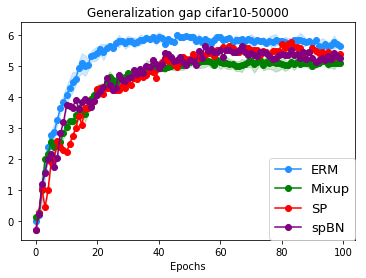

In [72]:
show_generalization_gap(data='cifar10',sample=50000)

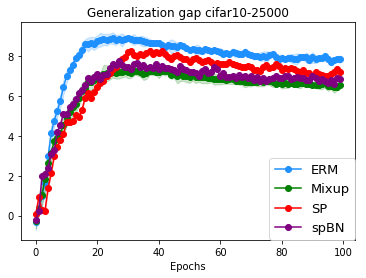

In [73]:
show_generalization_gap(data='cifar10',sample=25000)

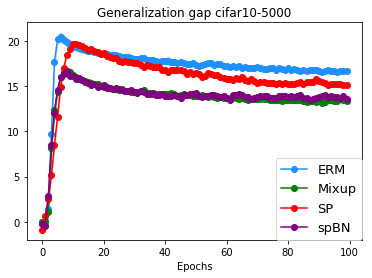

In [74]:
show_generalization_gap(data='cifar10',sample=5000)

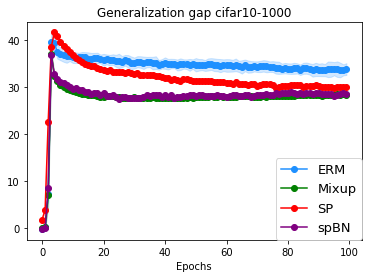

In [75]:
show_generalization_gap(data='cifar10',sample=1000)

In [81]:
show_generalization_gap(data='cifar10',sample=500)

IndexError: single positional indexer is out-of-bounds

In [ ]:
show_generalization_gap(data='cifar10',sample=100)

## CIFAR100 dataset

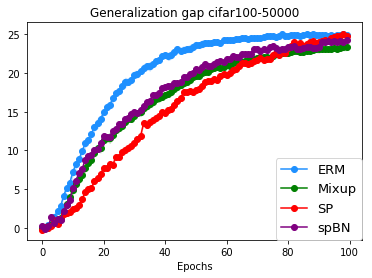

In [82]:
show_generalization_gap(data='cifar100',sample=50000)

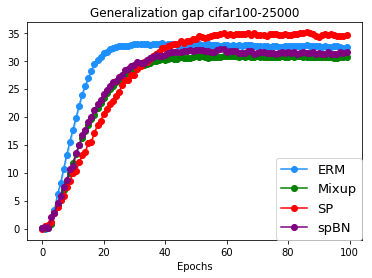

In [83]:
show_generalization_gap(data='cifar100',sample=25000)

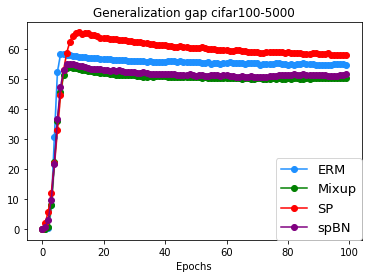

In [84]:
show_generalization_gap(data='cifar100',sample=5000)

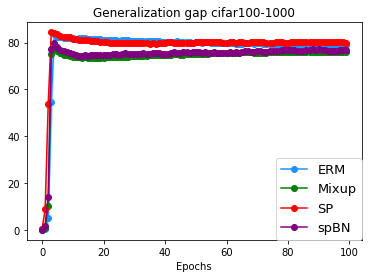

In [85]:
show_generalization_gap(data='cifar100',sample=1000)